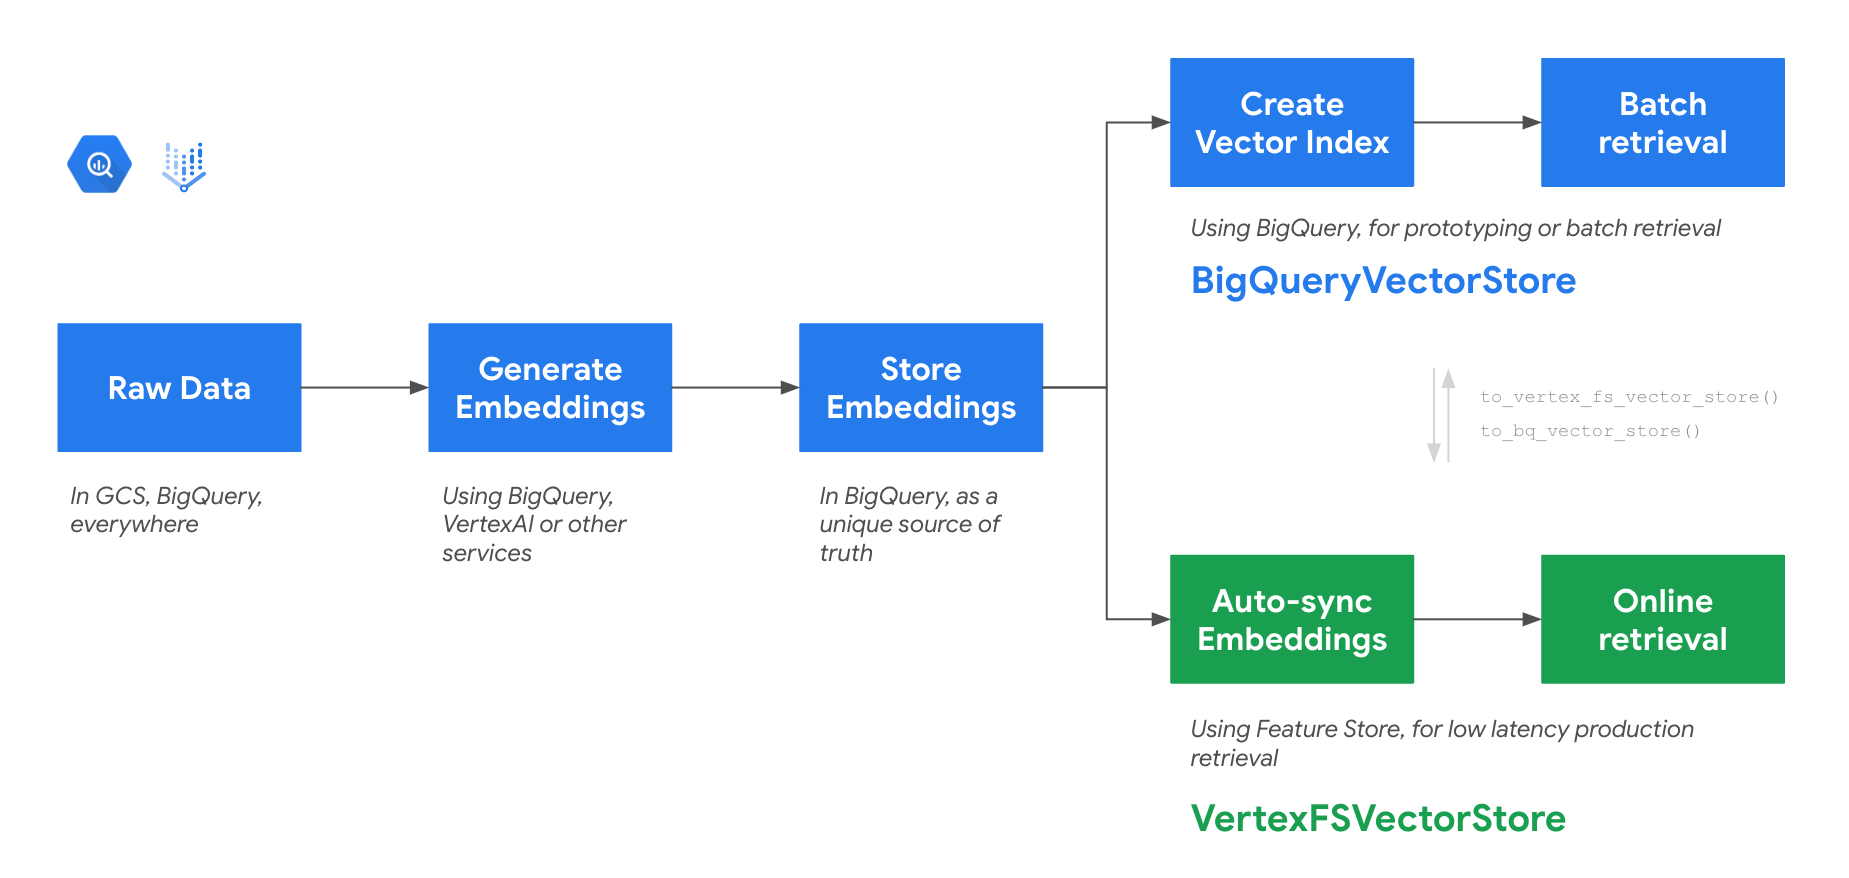

In [ ]:
!pip install rich
!pip install --upgrade --user --quiet google-cloud-aiplatform "langchain-google-vertexai" "langchain-google-community[featurestore]" pypdf==4.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

# **IMPORT LIBRARIES**

In [ ]:
import vertexai
from langchain.chains import RetrievalQA
from langchain.globals import set_debug
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_google_community import BigQueryVectorStore, VertexFSVectorStore
from langchain_google_vertexai import VertexAI, VertexAIEmbeddings
from rich import print

# **AUTHENTICATE**

In [ ]:
from google.colab import auth
auth.authenticate_user()

# **CONSTANTS**

In [ ]:
PROJECT_ID = "devhack-3f0c2" # @param {type:"string"}
LOCATION = "us-central1" # @param {type:"string"}
DATASET = "rag_test"  # @param {type:"string"}
TABLE = "softwarearchitecturetopics"  # @param {type:"string"}

# **INITIALIZE VERTEX AI**

In [ ]:
vertexai.init(project=PROJECT_ID, location=LOCATION)

# **DEFINE EMBEDDING MODEL**

In [ ]:
embedding_model = VertexAIEmbeddings(
    model_name="text-embedding-004", project=PROJECT_ID
)

# **LOAD DOCUMENTS**

In [ ]:
loader = PyPDFLoader("visualising-software-architecture.pdf")
documents = loader.load()

for document in documents:
  doc_md = document.metadata
  document_name = doc_md["source"].split("/")[-1]
  document.metadata = {"document_name": document_name}

print(f"# of documents loaded (pre-chunking) = {len(documents)}")

/root/.local/lib/python3.10/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


# of documents loaded (pre-chunking) = 196

# **CHUNKING**

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
  chunk_size=1000,
  chunk_overlap=50,
  separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
)
doc_splits = text_splitter.split_documents(documents)

for idx, split in enumerate(doc_splits):
  split.metadata["chunk"] = idx

print(f"# of documents = {len(doc_splits)}")
print(doc_splits[0].metadata)
print(doc_splits[0])

# of documents = 354

{'document_name': 'visualising-software-architecture.pdf', 'chunk': 0}

Document(
    metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 0},
    page_content='Visualise, document and explore your\nsoftware architecture\nSoftware Architecture for Developers
- Volume 2\nSimonBrown\nThisbookisforsaleat 
http://leanpub.com/visualising-software-architecture\nThisversionwaspublishedon2021-03-22\nThisisaLeanpubbook.Leanp
ubempowersauthorsandpublisherswiththeLean\nPublishingprocess. LeanPublishing 
istheactofpublishinganin-progressebookusing\nlightweighttoolsandmanyiterationstogetreaderfeedback,pivotuntilyouhave
theright\nbookandbuildtractiononceyoudo.\n©2015-2021SimonBrown'
)

# **CREATE RETRIEVER**

In [ ]:
bq_store = BigQueryVectorStore(
  project_id=PROJECT_ID,
  location=LOCATION,
  dataset_name=DATASET,
  table_name=TABLE,
  embedding=embedding_model,
)

bq_store.add_documents(documents=doc_splits)
langchain_retriever = bq_store.as_retriever()

INFO:langchain_google_community.bq_storage_vectorstores._base:BigQuery table devhack-3f0c2.rag_test.softwarearchitecturetopics initialized/validated as persistent storage. Access via BigQuery console:
 https://console.cloud.google.com/bigquery?project=devhack-3f0c2&ws=!1m5!1m4!4m3!1sdevhack-3f0c2!2srag_test!3ssoftwarearchitecturetopics


# **FIND SIMILARITIES**

In [ ]:
bq_store.similarity_search_by_vector(my_embedding)

# **LLM AUGMENTED KNOWLEDGE**

In [ ]:
llm = VertexAI(model_name="gemini-1.5-flash-002")

retrieval_qa = RetrievalQA.from_chain_type(
  llm=llm,
  chain_type="stuff",
  retriever=langchain_retriever
)
response = retrieval_qa.invoke("What is the C4 model?")
print("\n################ Final Answer ################\n")
print(response["result"])

################ Final Answer ################

The C4 model is a set of diagrams used to describe the static structure of a software system at varying levels of 
abstraction.  It's hierarchical, allowing for zooming in and out at different levels of detail.  The four levels 
are: System Context, Containers, Components, and Code.  It's not a design process, but rather a collection of 
diagrams to visualize the system.

# **BATCH RETRIEVAL**

In [ ]:
results = bq_store.batch_search(
  queries=["What is the C4 model?",
  "What is a container in C4 Model?"],
)
print(results)

[
    [
        [
            Document(
                metadata={
                    'doc_id': '0be1504238d04c478c29b14b6c73e673',
                    'document_name': 'visualising-software-architecture.pdf',
                    'chunk': 191,
                    'score': 0.7179368449938578
                },
                page_content='furtherexaggeratethedistancebetweenthe“Logical”and“Development”views.\nMypersonalpref
erenceistominimise,andinfact remove,thegapbetweenalogicalviewof\nwhat the system does and the real-world view of 
how that functionality is implemented in\ncode. As we’ve already discussed in previous chapters, this is about 
minimising the model-\ncode gap. In essence, the C4 model spans and combines what you might find in a 
“Logical\nView” and “Development View” into a single description of the static structure, across 
a\nnumberofdifferentlevelsofabstraction:\n•System Context 
:Thisshowsyouwhatthesystemdoesandhowitfitsintotheworld\naroundit(i.e.usersandothersoftwaresystems).'
            ),
            0.7179368449938578
        ],
        [
            Document(
                metadata={
                    'doc_id': '683f64dc1d2646f2bf62da70645725cc',
                    'document_name': 'visualising-software-architecture.pdf',
                    'chunk': 91,
                    'score': 0.7229246295591248
                },
                page_content='3.The C4 
model\nWithasharedvocabularyinmind,wecannowmoveontodrawsomediagramsatvarying\nlevelsofabstractiontovisualisethestat
icstructureofasoftwaresystem.Icallthisthe“C4\nmodel”;(System)Context,Containers,ComponentsandCode.\n1.System 
Context : A System Context diagram provides a starting point, showing 
how\nthesoftwaresysteminscopefitsintotheworldaroundit.\n2.Containers : A Container diagram zooms into the software 
system in scope, showing\nthehigh-leveltechnicalbuildingblocks(containers)andhowtheyinteract.\n3.Components 
:AComponentdiagramzoomsintoanindividualcontainer,showingthe\ncomponentsinsideit.\n4.Code: A code (e.g. UML class) 
diagram can be used to zoom into an individual\ncomponent,showinghowthatcomponentisimplemented.'
            ),
            0.7229246295591248
        ],
        [
            Document(
                metadata={
                    'doc_id': '8d2158e6039844528c60d111c69fd399',
                    'document_name': 'visualising-software-architecture.pdf',
                    'chunk': 25,
                    'score': 0.7398108307067074
                },
                page_content='29.1 Background . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . 179'
            ),
            0.7398108307067074
        ],
        [
            Document(
                metadata={
                    'doc_id': '4068dc35db764c9d9f111032e9d64972',
                    'document_name': 'visualising-software-architecture.pdf',
                    'chunk': 92,
                    'score': 0.7508401889014283
                },
                page_content='TheC4model 33\nA summary of the C4 model\n3.1Hierarchical maps of your 
code\nYoucanthinkoftheC4diagramsasbeingasetofmapsforasoftwaresystem,whichprovides\nyouwiththeabilitytozoominandouta
tvaryinglevelsofdetail. Shneiderman’smantra 
is\nasimpleconceptforunderstandingandvisualisinglargequantitiesofdata,butitfitsreally\nnicelywiththeC4modelbecausei
t’shierarchical.\nOverviewfirst,zoomandfilter,thendetails-on-demand'
            ),
            0.7508401889014283
        ],
        [
            Document(
                metadata={
                    'doc_id': '19d549fe728f4b88ac466032e4afb90b',
                    'document_name': 'visualising-software-architecture.pdf',
                    'chunk': 96,
                    'score': 0.7581172010829454
                },
                page_content='said, and we’ll cover this later, while the C4 model describes diagrams covering four
levels\nof abstraction, you don’t necessarily need to create every diagram at ever

# **VECTOR SEARCH WITH FEATURESTORE**

In [ ]:
vertex_fs = bq_store.to_vertex_fs_vector_store()

INFO:langchain_google_community.bq_storage_vectorstores._base:BigQuery table devhack-3f0c2.rag_test.softwarearchitecturetopics initialized/validated as persistent storage. Access via BigQuery console:
 https://console.cloud.google.com/bigquery?project=devhack-3f0c2&ws=!1m5!1m4!4m3!1sdevhack-3f0c2!2srag_test!3ssoftwarearchitecturetopics
INFO:langchain_google_community.bq_storage_vectorstores._base:Creating feature store online store
INFO:langchain_google_community.bq_storage_vectorstores._base:name: "projects/823002731253/locations/us-central1/featureOnlineStores/rag_test"

INFO:langchain_google_community.bq_storage_vectorstores._base:name: "projects/823002731253/locations/us-central1/featureOnlineStores/rag_test"

INFO:langchain_google_community.bq_storage_vectorstores._base:VertexFSVectorStore initialized with Feature Store Vector Search. 
Optional batch serving available via .to_bq_vector_store() method.


# **SYNC DATA**

In [ ]:
vertex_fs.sync_data()

INFO:vertexai.resources.preview.feature_store.feature_online_store:Creating FeatureView
INFO:vertexai.resources.preview.feature_store.feature_online_store:Create FeatureView backing LRO: projects/823002731253/locations/us-central1/featureOnlineStores/rag_test/featureViews/softwarearchitecturetopics/operations/2677970967287824384
INFO:vertexai.resources.preview.feature_store.feature_online_store:FeatureView created. Resource name: projects/823002731253/locations/us-central1/featureOnlineStores/rag_test/featureViews/softwarearchitecturetopics
INFO:vertexai.resources.preview.feature_store.feature_online_store:To use this FeatureView in another session:
INFO:vertexai.resources.preview.feature_store.feature_online_store:feature_view = aiplatform.FeatureView('projects/823002731253/locations/us-central1/featureOnlineStores/rag_test/featureViews/softwarearchitecturetopics')
INFO:langchain_google_community.bq_storage_vectorstores._base:Sync ongoing, waiting for 30 seconds.
INFO:langchain_google

# **SIMILARITY SEARCH WITH FEATURE ONLINE STORE**

In [ ]:
print(vertex_fs.similarity_search("Hello world"))

[
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 57},
        page_content='worldisaDLL.\nAnd herein lies the ambiguity. What happens if you put a JAR file on a Unix 
box? Well,\nthe answer is not very much other than it takes up some disk space. And cron (the Unix\nscheduler) 
doesn’t execute JAR files unless they are really standalone console 
applications,\nthesortthathavea“publicstaticvoidmain”methodasaprogramentrypoint.Bydeduction\nthen,Ithinkbothofthose
JARfilesareactuallystandaloneapplicationsandthat’swhatI’d'
    ),
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 212},
        page_content='do it, everybody shouldstrive for good code that’s easy to read, understand and 
maintain.\nButthecodedoesn’ttellthewholestory.\nLet’s imagine you’ve started work on a new software project that’s 
already underway. The\nmajorbuildingblocksareinplaceandsomeofthefunctionalityhasalreadybeendelivered.\nYou start up
your development machine, download the code from the source code control\nsystem and load it up into your 
development environment. What do you do next and how\ndoyoustartbeingproductive?'
    ),
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 309},
        page_content='(Structurizr doesn’t provide any auto-layout facilities), is something like the 
following.\nHere’sthecontextdiagram.'
    ),
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 232},
        page_content='Context 107\n13.5 
Required\nYes,allsoftwareguidebooksshouldincludeaninitialcontextsectiontosetthescene.'
    ),
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 79},
        page_content='some repositories for data access. There are also some domain and util classes too. If you'
    )
]

In [ ]:
langchain_retriever = vertex_fs.as_retriever()
results = langchain_retriever.invoke("What is C4 Model?")
print(results)

[
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 191},
        page_content='furtherexaggeratethedistancebetweenthe“Logical”and“Development”views.\nMypersonalpreferenceis
tominimise,andinfact remove,thegapbetweenalogicalviewof\nwhat the system does and the real-world view of how that 
functionality is implemented in\ncode. As we’ve already discussed in previous chapters, this is about minimising 
the model-\ncode gap. In essence, the C4 model spans and combines what you might find in a “Logical\nView” and 
“Development View” into a single description of the static structure, across 
a\nnumberofdifferentlevelsofabstraction:\n•System Context 
:Thisshowsyouwhatthesystemdoesandhowitfitsintotheworld\naroundit(i.e.usersandothersoftwaresystems).'
    ),
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 91},
        page_content='3.The C4 
model\nWithasharedvocabularyinmind,wecannowmoveontodrawsomediagramsatvarying\nlevelsofabstractiontovisualisethestat
icstructureofasoftwaresystem.Icallthisthe“C4\nmodel”;(System)Context,Containers,ComponentsandCode.\n1.System 
Context : A System Context diagram provides a starting point, showing 
how\nthesoftwaresysteminscopefitsintotheworldaroundit.\n2.Containers : A Container diagram zooms into the software 
system in scope, showing\nthehigh-leveltechnicalbuildingblocks(containers)andhowtheyinteract.\n3.Components 
:AComponentdiagramzoomsintoanindividualcontainer,showingthe\ncomponentsinsideit.\n4.Code: A code (e.g. UML class) 
diagram can be used to zoom into an individual\ncomponent,showinghowthatcomponentisimplemented.'
    ),
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 95},
        page_content='TheC4model 35\nCode: Details on demand\nI might optionally progress deeper into the hierarchy
to show the code-level elements (e.g.\nclasses, interfaces, objects, functions, etc) that make up a particular 
component. 
Ultimately\nthough,thisdetailresidesinthecodeand,assoftwaredevelopers,wecangetthatondemand\nviaourIDEs.\nDifferent 
diagrams, different stories\nNext time you’re asked to create some software architecture diagrams (whether that’s 
to\nunderstandanexistingsystem,presentasystemoverview,ordosomesoftwarearchaeology),\nmy advice is to keep 
Shneiderman’s mantra in mind. Start at the top and work into the\ndetail, creating a story that gets deeper into 
the detail as it progresses. The different levels\nof diagrams allow you to tell different stories to different 
audiences; some of who will be\ntechnical,somenot.\nAs a quick note, the C4 model is not a description of a design 
process , it’s just a collection\nof diagrams that you can use to describe the static structure of a software 
system. That'
    ),
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 92},
        page_content='TheC4model 33\nA summary of the C4 model\n3.1Hierarchical maps of your 
code\nYoucanthinkoftheC4diagramsasbeingasetofmapsforasoftwaresystem,whichprovides\nyouwiththeabilitytozoominandouta
tvaryinglevelsofdetail. Shneiderman’smantra 
is\nasimpleconceptforunderstandingandvisualisinglargequantitiesofdata,butitfitsreally\nnicelywiththeC4modelbecausei
t’shierarchical.\nOverviewfirst,zoomandfilter,thendetails-on-demand'
    ),
    Document(
        metadata={'document_name': 'visualising-software-architecture.pdf', 'chunk': 96},
        page_content='said, and we’ll cover this later, while the C4 model describes diagrams covering four 
levels\nof abstraction, you don’t necessarily need to create every diagram at every level. 
My\nrecommendationisthatallteamscreateSystemContextandContainerdiagrams,andreally\nthinkaboutwhetherComponentandCod
ediagramsprovideenoughbenefitconsideringthe\ncostofcreatingandkeepingthemuptodate.'
    )
]

# **CLEANING UP**

In [ ]:
vertex_fs.feature_view.delete()
vertex_fs.online_store.delete()